# Convolutional VAEs

## Linear VAEs

In [1]:
import matplotlib.pyplot as plt
import medmnist  # pip install medmnist ก่อน
from medmnist import INFO
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
# Set up device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

No GPU available!


In [3]:
# Get the information about the MedMNIST dataset
info = INFO['chestmnist']
info

{'python_class': 'ChestMNIST',
 'description': 'The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/chestmnist.npz?download=1',
 'MD5': '02c8a6516a18b556561a56cbdd36c4a8',
 'task': 'multi-label, binary-class',
 'label': {'0': 'atelectasis',
  '1': 'cardiomegaly',
  '2': 'effusion',
  '3': 'infiltration',
  '4': 'mass',
  '5': 'nodule',
  '6': 'pneumonia',
  '7': 'pneumothorax',
  '8': 'consolidation',
  '9': 'edema',
  '10': 'emphysema',
  '11': 'fibrosis',
  '12': 'pleural',
  '13': 'hernia'},
 'n_channels': 1,
 'n_samples': {'train': 78468, 'val': 11219, 'test': 22433},
 'license': 'CC BY 4.0'}

In [4]:
DataClass = getattr(medmnist, info['python_class'])

# Load the data
train_dataset = DataClass(split='train', transform=transforms.ToTensor(), download=True)
test_dataset = DataClass(split='test', transform=transforms.ToTensor(), download=True)
pil_dataset = DataClass(split='train', download=True)

# Encapsulate data into the data loader form
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*batch_size, shuffle=False)

Using downloaded and verified file: C:\Users\Khuna\.medmnist\chestmnist.npz


Using downloaded and verified file: C:\Users\Khuna\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Khuna\.medmnist\chestmnist.npz


Batch shape: torch.Size([32, 1, 28, 28])


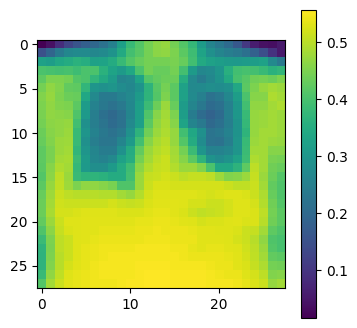

In [5]:
# Get a training batch
images, labels = next(iter(train_loader))

# torch.Size(num_images, num_channels, height_image, width_image)
print("Batch shape:", images.shape)

# Plot the first image in the batch
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(images[0].squeeze())
fig.colorbar(im);

In [6]:
# Create an encoder and a decoder to be used in a VAE
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(784, 512), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.layerMu = nn.Sequential(nn.Linear(128, 16))
        self.layerSigma = nn.Sequential(nn.Linear(128, 16))

    def forward(self, x):
        '''
        Parameters
        ----------
        x : float

            Input image

        '''
        x = x.flatten(start_dim=1)  # Reshape the input into a vector (nD to 1D)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        mu = self.layerMu(x)  # Turn the output of the Encoder into Mu
        sigma = torch.exp(self.layerSigma(x))  # Exponential activation ensures the positivity for Sigma
        return mu, sigma
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layerLatent = nn.Sequential(nn.Linear(16, 128))
        self.layer1 = nn.Sequential(nn.Linear(128, 256), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(256, 512), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(512, 784), nn.Sigmoid())

    def forward(self, z):
        '''
        Parameters
        ----------
        z : float

            Latent variable

        '''
        z = self.layerLatent(z)
        z = self.layer1(z)
        z = self.layer2(z)
        z = self.layer3(z)
        z = z.reshape((-1, 1, 28, 28))  # Reshape the vector into a (28x28) grayscale image
        return z

In [7]:
# Create a VAE
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.distribution = torch.distributions.Normal(0, 1)  # Sample from N(0,1)

    def get_latent(self, mu, sigma):
        z = mu + sigma * self.distribution.sample(mu.shape).to(device)  # Latent variable
        latent_loss = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()  # Latent loss
        return z, latent_loss

    def forward(self, x):
        mu, sigma = self.encoder(x)
        z, latent_loss = self.get_latent(mu, sigma)  ## (2) Generate the latent vector sample
        x_hat = self.decoder(z)
        return x_hat, latent_loss

In [8]:
# Define a function for training the VAE
def train(vae, data, epochs=10):
    optimizer = torch.optim.Adam(vae.parameters())
    for epoch in range(epochs):
        for batch, label in tqdm(data):
            batch = batch.to(device)
            optimizer.zero_grad()
            x_hat, latent_loss = vae(batch)
            generation_loss = ((batch - x_hat)**2).sum()  # L2 loss
            loss = generation_loss + latent_loss  
            loss.backward()
            optimizer.step()
    return vae  # Return the trained VAE

In [9]:
# Define a function for training the VAE
def train(vae, data, epochs=10):
    optimizer = torch.optim.Adam(vae.parameters())
    for epoch in range(epochs):
        for batch, label in data:
            batch = batch.to(device)
            optimizer.zero_grad()
            x_hat, latent_loss = vae(batch)
            generation_loss = ((batch - x_hat)**2).sum()  # L2 loss
            loss = generation_loss + latent_loss  
            loss.backward()
            optimizer.step()
    return vae  # Return the trained VAE

In [10]:
# Initialise a VAE and train it
vae = VAE(Encoder(), Decoder()).to(device)
vae = train(vae, train_loader, 10)

KeyboardInterrupt: 

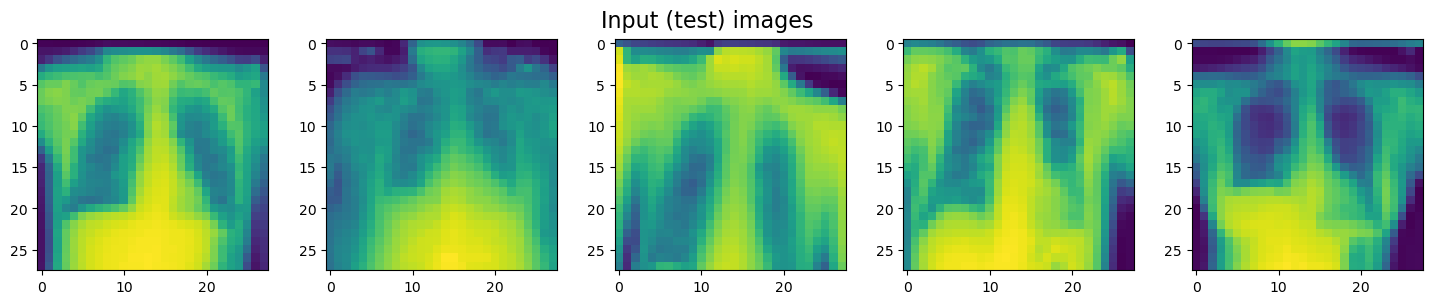

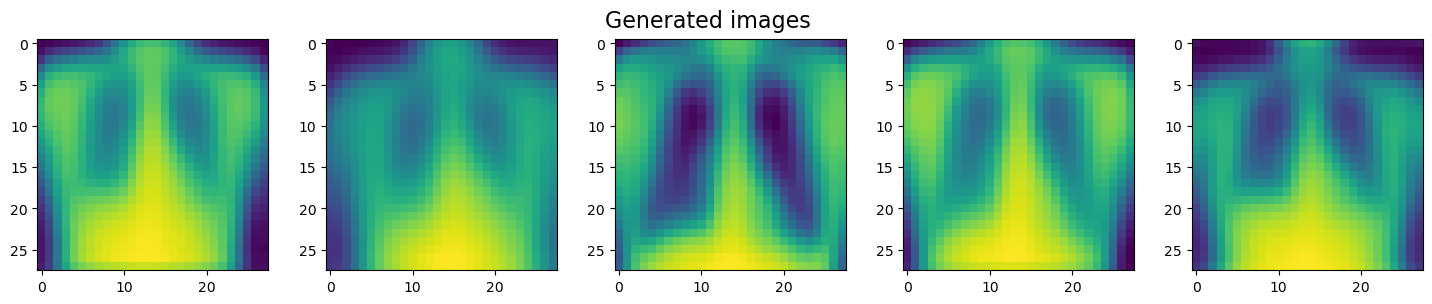

In [12]:
images, labels = next(iter(test_loader))  # Get a test batch (64 images)

# Randomly choose 5 images generated by the trained VAE given a test batch
fig0, ax0 = plt.subplots(1, 5, figsize=(18, 3))
fig1, ax1 = plt.subplots(1, 5, figsize=(18, 3))
for n, idx in enumerate(torch.randint(0, 63, (5,))):
    recon, _ = vae(images[idx].unsqueeze(0).cpu())
    ax0[n].imshow(images[idx].squeeze())
    ax1[n].imshow(recon.cpu().detach().squeeze())
fig0.suptitle("Input (test) images", fontsize=16)
fig1.suptitle("Generated images", fontsize=16);

## Mode collapse

จากภาพด้านบน จะเห็นได้ว่า VAE ของเราที่เทรนแล้ว สร้างภาพออกมาหน้าตาคล้าย ๆ กันหมด

Generative model มีแนวโน้มที่จะเข้าสู่ <b>mode collapse</b> นั่นคือ model จะสร้างภาพที่เป็นภาพเฉลี่ยของ dataset แทนที่จะสร้างภาพใหม่

## Convolutional VAEs

เพื่อให้ VAE สร้างภาพที่ซับซ้อนมากขึ้น เราต้องเพิ่ม complexity ของ VAE วิธีการหนึ่งที่ทำได้คือ เปลี่ยนจาก linear layer เป็น convolutional layer

ใน convolutional encoder เราจะ
- เพิ่มจำนวน channel โดยใช้ `torch.nn.Conv2d`
- ลด spatial dimension ของภาพโดยใช้ `torch.nn.MaxPool2d`
- กำหนด kernel size และ padding เพื่อให้ convoluted image มีขนาด $2^n$ เพื่อให้ง่ายต่อการ subsampling

ใน convolutional decoder เราจะ
- ลดจำนวน channel โดยใช้ `torch.nn.Conv2d`
- เพิ่ม spatial dimension ของภาพโดยใช้ `torch.nn.Upsample`
- เอา padding ออกจาก output

In [13]:
# Create a convolutional encoder and a convolutional decoder to be used in a VAE
class Conv_Encoder(nn.Module):
    def __init__(self):
        super(Conv_Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=3, padding=3),  # Input มีขนาด 28x28 มี padding=3 กลายเป็น 34x34
                                                         # 34x34 ถูก convoluted กลายเป็น 32x32 (เพราะ kernel_size=3)
            nn.GELU(),
            nn.MaxPool2d(2)                              # 32x32 ถูก subsampled กลายเป็น 16x16
        )  # 28x28 => 16x16

        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 40, kernel_size=3, padding="same"),  # padding="same" ทำให้ convoluted image มีขนาดเท่า image เดิม
                                                               # นั่นคือ 16x16
            nn.MaxPool2d(2)                                    # 16x16 ถูก subsampled กลายเป็น 8x8
        )  # 16x16 => 8x8

        self.layer3 = nn.Sequential(
            nn.Conv2d(40, 60, 3, padding="same"),
            nn.GELU(),
            nn.MaxPool2d(2)
        )  # 8x8 => 4x4

        self.layerMu = nn.Sequential(
            nn.Conv2d(60, 120, 1),
        )  # 4x4 => 4x4

        self.layerSigma = nn.Sequential(
            nn.Conv2d(60, 120, 1),
        )  # 4x4 => 4x4

    def forward(self, x):
        '''
        Parameters
        ----------
        x : float

            Input image

        '''
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        mu =  self.layerMu(x3)
        sigma = self.layerSigma(x3)
        return mu, sigma

class Conv_Decoder(nn.Module):
    def __init__(self):
        super(Conv_Decoder, self).__init__()

        self.layerLatent = nn.Sequential(
            nn.Conv2d(120, 60, 1),
            nn.GELU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )  # 4x4 => 8x8

        self.layer1 = nn.Sequential(
            nn.Conv2d(60, 40, 3, padding='same'),
            nn.GELU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )  # 8x8 => 16x16

        self.layer2 = nn.Sequential(
            nn.Conv2d(40, 20, 3, padding='same'),
            nn.GELU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )  # 16x16 => 32x32

        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 1, 3, padding='same'),
            nn.GELU(),
            nn.Sigmoid()
        )  # 32x32 => 32x32

    def forward(self, z):  # Custom pytorch modules should follow this structure
        '''
        Parameters
        ----------
        z : float

            Latent variable

        '''
        z = self.layerLatent(z)
        z1 = self.layer1(z)
        z2 = self.layer2(z1)
        z3 = self.layer3(z2)
        x_hat = z3[:, :, 2: -2, 2: -2]  # Crop the output
        return x_hat

In [14]:
# Initialise a convolutional VAE and train it
conv_vae = VAE(Conv_Encoder(), Conv_Decoder()).to(device)
conv_vae = train(conv_vae, train_loader, 10)

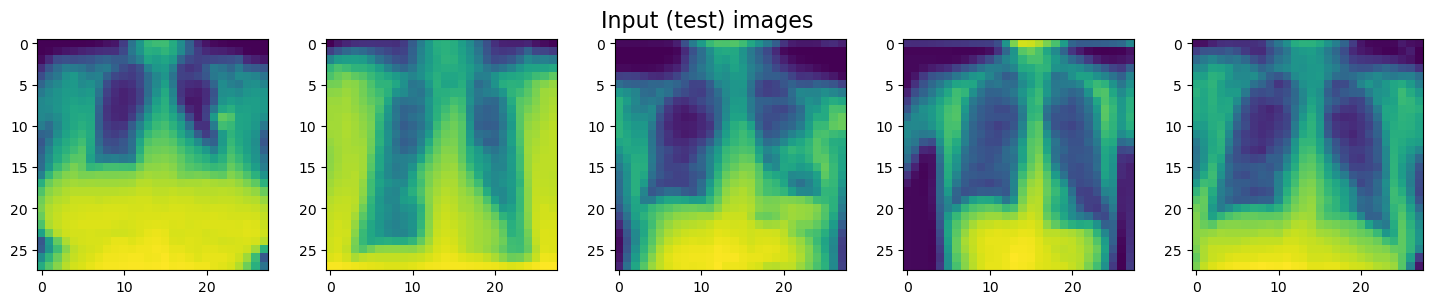

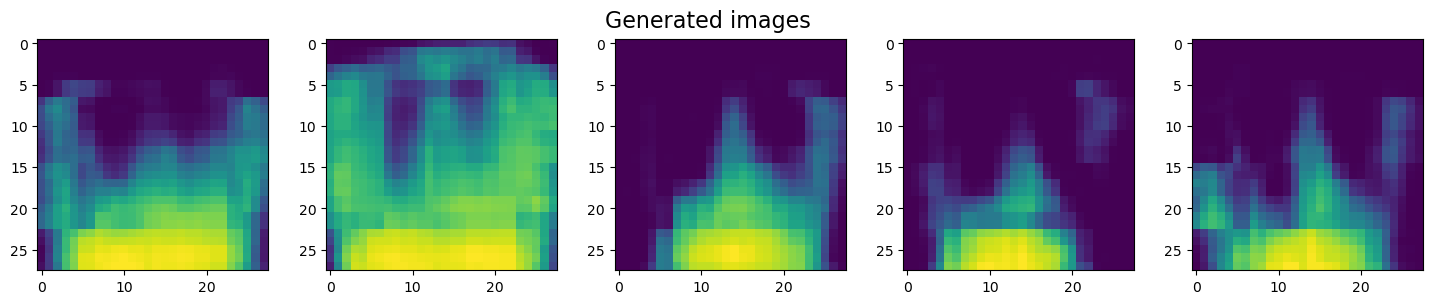

In [16]:
images, labels = next(iter(test_loader))  # Get a test batch (64 images)

# Randomly choose 5 images generated by the trained convolutional VAE given a test batch
fig0, ax0 = plt.subplots(1, 5, figsize=(18, 3))
fig1, ax1 = plt.subplots(1, 5, figsize=(18, 3))
for n, idx in enumerate(torch.randint(0, 63, (5,))):
    recon, _ = conv_vae(images[idx].unsqueeze(0).cpu())
    ax0[n].imshow(images[idx].squeeze())
    ax1[n].imshow(recon.cpu().detach().squeeze())
fig0.suptitle("Input (test) images", fontsize=16)
fig1.suptitle("Generated images", fontsize=16);